# Foundations of Computational Economics #32

by Fedor Iskhakov, ANU

<img src="_static/img/dag3logo.png" style="width:256px;">

In [ ]:
ω

## Cake eating model with discretized choice

<img src="_static/img/lab.png" style="width:64px;">

<img src="_static/img/youtube.png" style="width:65px;">

[https://youtu.be/EDcCoXkIU34](https://youtu.be/EDcCoXkIU34)

Description: Using function interpolation to solve cake eating problem with discretized choice.

### Cake eating problem

<img src="_static/img/cake.png" style="width:128px;">

  
- Cake of initial size $ W_0 $  
- How much of the cake to eat each period $ t $, $ c_t $?  
- Time is discrete, $ t=1,2,\dots,\infty $  
- What is not eaten in period $ t $ is left for the future $ W_{t+1}=W_t-c_t $  

### Bellman equation

$$
V(W_{t})=\max_{0 \le c_{t} \le W_t}\big\{\log(c_{t})+\beta V(\underset{=W_{t+1}}{\underbrace{W_{t}-c_{t}}})\big\}
$$

$$
c^{\star}(W_t)=\arg\max_{0 \le c_{t} \le W_t}\big\{\log(c_{t})+\beta V(\underset{=W_{t+1}}{\underbrace{W_{t}-c_{t}}})\big\}
$$

### Recap: components of the dynamic model

- **State variables** — vector of variables that describe all relevant
  information about the modeled decision process, $ W_t $  
- **Decision variables** — vector of variables describing the choices,
  $ c_t $  
- **Instantaneous payoff** — utility function, $ u(c_t)=\log(c_t) $, with
  time separable discounted utility  
- **Motion rules** — agent’s beliefs of how state variable evolve
  through time, conditional on choices, $ W_{t+1}=W_t-c_t $  
- **Value function** — maximum attainable utility, $ V(W_t) $  
- **Policy function** — mapping from state space to action space that
  returns the optimal choice, $ c^{\star}(W_t) $  

### Value function iterations (VFI) solution

Numerically solve

$$
V(W) = \max_{0 \le c \le W} \big[ u(c)+\beta V(W-c) \big ]
$$

Solve the **functional fixed point equation** $ T({V})(W) = V(W) $ for $ V(W) $, where

$$
T(V)(W) \equiv \max_{0 \le c \le W} \big[u(c)+\beta V(W-c)\big]
$$

### VFI algorithm

- Start with an arbitrary guess $ V_0(W) $
  (will see next time that the initial guess is not important)  
- At each iteration $ i $ compute  


$$
\begin{eqnarray*}
V_i(W) = T(V_{i-1})(W) &=&
\max_{0 \le c \le W} \big\{u(c)+\beta V_{i-1}(W-c) \big \}  \\
c_{i-1}(W) &=&
\underset{0 \le c \le W}{\arg\max} \big\{u(c)+\beta V_{i-1}(W-c) \big \}
\end{eqnarray*}
$$

- Repeat until convergence  

### Numerical implementation of the Bellman operator

- Cake is continuous $ \rightarrow $ value function is a function
  of continuous variable  
- Solution: **discretize** $ W $
  Construct a *grid* (vector) of cake-sizes
  $ \vec{W}\in\{0,\dots\overline{W}\} $  


$$
V_{i}(\vec{W})=\max_{0 \le c \le \vec{W}}\{u(c)+\beta V_{i-1}(\vec{W}-c)\}
$$

- Compute value and policy function sequentially point-by-point  
- May need to compute the value function *between grid points*
  $ \Rightarrow $ Interpolation and function approximation  

### Solution “on the grid”

- allows to avoid computation of value function between the grid points  
- but have to rewrite the model with choices in terms of $ W_{t+1} $  
- consumption is then taken as the difference $ W_{t+1}-W_t $  
- very crude representation of consumption choice, thus terribly low accuracy of the solution  

In [1]:
import numpy as np
class cake_ongrid():
    '''Simple class to implement cake eating problem on the grid'''

    def __init__(self,beta=.9, Wbar=10, ngrid=50):
        '''Initializer'''
        self.beta = beta    # Discount factor
        self.Wbar = Wbar    # Upper bound on cake size
        self.ngrid = ngrid  # Number of grid points
        self.epsilon = np.finfo(float).eps # smallest positive float number
        self.grid = np.linspace(self.epsilon,Wbar,ngrid) # grid for both state and decision space

    def bellman(self,V0):
        '''Bellman operator, V0 is one-dim vector of values on grid'''
        c = self.grid - self.grid[:,np.newaxis] # current state in columns and choices in rows
        c[c==0] = self.epsilon # add small quantity to avoid log(0)
        mask = c>0 # mask off infeasible choices
        matV1 = np.full((self.ngrid,self.ngrid),-np.inf) # init V with -inf
        matV0 = np.repeat(V0.reshape(self.ngrid,1),self.ngrid,1) #current value function repeated in columns
        matV1[mask] = np.log(c[mask])+self.beta*matV0[mask] # maximand of the Bellman equation
        V1 = np.amax(matV1,axis=0,keepdims=False) # maximum in every column
        c1 = self.grid - self.grid[np.argmax(matV1,axis=0)] # consumption (index of maximum in every column)
        return V1, c1

    def solve(self, maxiter=1000, tol=1e-4, callback=None):
        '''Solves the model using VFI (successive approximations)'''
        V0=np.log(self.grid) # on first iteration assume consuming everything
        for iter in range(maxiter):
            V1,c1=self.bellman(V0)
            if callback: callback(iter,self.grid,V1,c1) # callback for making plots
            if np.all(abs(V1-V0) < tol):
                break
            V0=V1
        else:  # when i went up to maxiter
            print('No convergence: maximum number of iterations achieved!')
        return V1,c1

### Comparison to analytic solution

In video 30 we derived the analytic solution of the cake eating problem

$$
c^{\star}(W) =  \frac {W} {1 + \beta B} = \frac {W} {1 + \frac{\beta}{1-\beta}} = (1-\beta)W
$$

$$
V(W) = \frac{\log(W)}{1-\beta} + \frac{\log(1-\beta)}{1-\beta} + \frac{\beta \log(\beta)}{(1-\beta)^2}
$$

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

def check_analytic(model):
    '''Check the cake eating numerical solution against the analytic solution'''
    # analytic solution
    aV = lambda w: np.log(w)/(1 - model.beta) + np.log(1 - model.beta)/(1 - model.beta) + model.beta* np.log(model.beta)/((1 - model.beta)**2)
    aP = lambda w: (1 - model.beta) * w
    grid = model.grid  # grid from the model
    xg = np.linspace(model.epsilon,model.Wbar,1000)  # dense grid for analytical solution
    V,policy = model.solve()  # solve the model
    # make plots
    fig1, (ax1,ax2) = plt.subplots(1,2,figsize=(14,8))
    ax1.grid(b=True, which='both', color='0.65', linestyle='-')
    ax2.grid(b=True, which='both', color='0.65', linestyle='-')
    ax1.set_title('Value functions')
    ax2.set_title('Policy functions')
    ax1.set_xlabel('Cake size, W')
    ax2.set_xlabel('Cake size, W')
    ax1.set_ylabel('Value function')
    ax2.set_ylabel('Policy function')
    ax1.plot(grid[1:],V[1:],linewidth=1.5,label='Numerical')
    ax1.plot(xg,aV(xg),linewidth=1.5,label='Analytical')
    ax2.plot(grid,policy,linewidth=1.5,label='Numerical')
    ax2.plot(grid,aP(grid),linewidth=1.5,label='Analytical')
    ax1.legend()
    ax2.legend()
    plt.show()

C:\Users\rudol\AppData\Local\Temp\ipykernel_18496\2013333407.py:14: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax1.grid(b=True, which='both', color='0.65', linestyle='-')
C:\Users\rudol\AppData\Local\Temp\ipykernel_18496\2013333407.py:15: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax2.grid(b=True, which='both', color='0.65', linestyle='-')


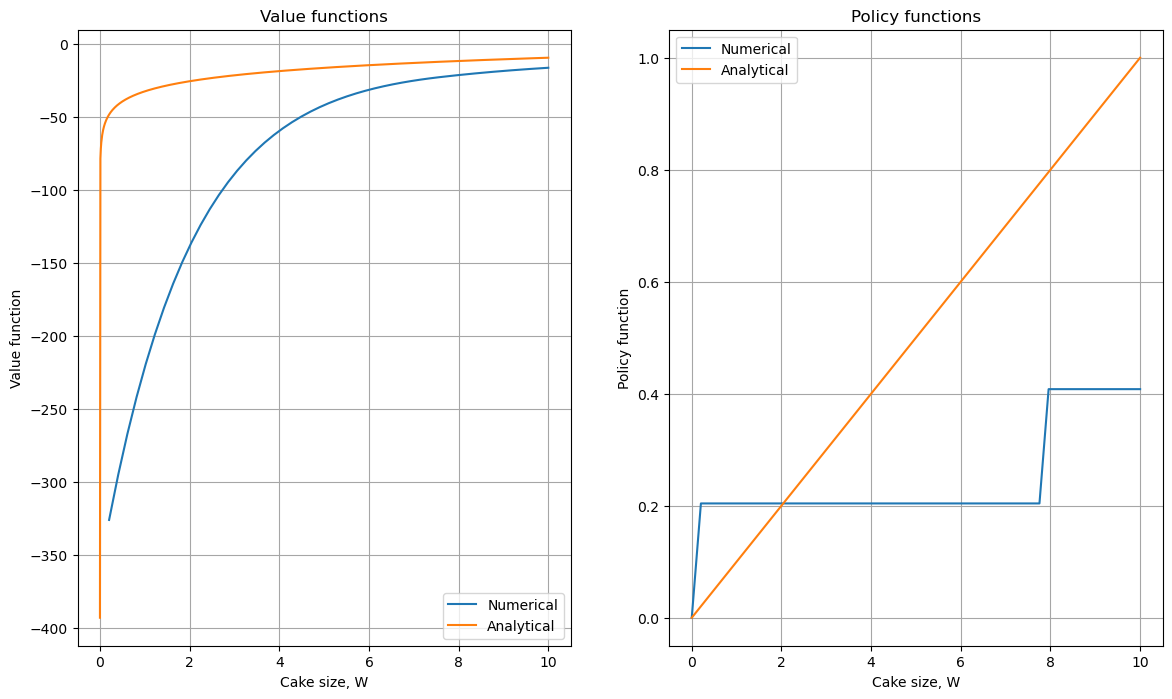

In [3]:
m1 = cake_ongrid(beta=0.9,Wbar=10,ngrid=50)
check_analytic(m1)

#### Interpolation of the value function

Rather than trying to avoid interpolation by rewriting the problem
in terms of the next period choice, today we will

- discretize the choice variable to avoid solving optimization problem for
  each value of wealth  
- use interpolation of already computed next period value function  

### Cake eating with discretized choices

*Control for grid over state space separately from the discretization of
the choice variables to increase accuracy*

- As before solve cake eating Bellman equation by VFI  
- Discretize state space with $ \vec{W}\in\{0,\dots\overline{W}\} $  
- Discretize decision space with
  $ \vec{D}\in\{0,\dots\overline{D}\} $, usually
  $ \overline{D}=\overline{W} $  


$$
V_{i}(\vec{W})=\max_{c \in \vec{D}}\{u(c)+\beta V_{i-1}(\vec{W}-c)\}
$$

- Compute value/policy function point-by-point on grid $ \vec{W} $  
- Find the maximum over the points of grid $ \vec{D} $ that satisfy
  the choice set condition $ 0 \le \vec{D} \le W $  
- In each iteration, the value function $ V_{i}(\vec{W}) $ is
  computed on a set of grid points  
- But for iteration $ i+1 $ we need to compute
  $ V_{i}(\vec{W}-c)\}=V_{i}(\vec{W}-\vec{D})\} $  
- **Interpolation of the value function**  

In [ ]:
# CODE DEVELOPED IN THE VIDEO

import numpy as np
from scipy import interpolate # Interpolation routines

class cake_discretized():
    '''Class to implement the cake eating model with discretized choice'''

    def __init__(self,beta=.9, Wbar=10, ngrid=50, nchgrid=100, optim_ch=True):
        '''Initializer'''
        self.beta = beta    # Discount factor
        self.Wbar = Wbar    # Upper bound on cake size
        self.ngrid = ngrid  # Number of grid points
        self.nchgrid = nchgrid  # Number of grid points for choice grid
        self.epsilon = np.finfo(float).eps # smallest positive float number
        self.grid = np.linspace(self.epsilon,Wbar,ngrid) # grid for state space
        self.chgrid = np.linspace(self.epsilon,Wbar,nchgrid) # grid for decision space
        self.optim_ch = optim_ch

    def bellman(self,V0):
        '''Bellman operator, V0 is one-dim vector of values on state grid'''
        c = self.chgrid[:,np.newaxis]  # column vector
        if self.optim_ch:
            c = c + np.zeros(self.ngrid)  # matrix of consumption values
            c *= self.grid/self.Wbar  # scale choices to ensure c<W
        W = self.grid  # one-dim (like row vector)
        interp = interpolate.interp1d(self.grid,V0,bounds_error=False,fill_value='extrapolate')
        matV1 = np.log(c) + self.beta * interp(W-c)
        matV1[c>W] = -np.inf  # infeasible choices
        V1 = np.amax(matV1,axis=0,keepdims=False) # maximum in every column
        if self.optim_ch:
            c1 = c[np.argmax(matV1,axis=0),np.arange(self.ngrid)]
        else:
            c1 = c[np.argmax(matV1,axis=0)]  # consumption (index of maximum in every column)
        return V1, c1

    def solve(self, maxiter=1000, tol=1e-4, callback=None):
        '''Solves the model using VFI (successive approximations)'''
        V0=np.log(self.grid) # on first iteration assume consuming everything
        for iter in range(maxiter):
            V1,c1=self.bellman(V0)
            if callback: callback(iter,self.grid,V1,c1) # callback for making plots
            if np.all(abs(V1-V0) < tol):
                break
            V0=V1
        else:  # when i went up to maxiter
            print('No convergence: maximum number of iterations achieved!')
        return V1,c1

In [ ]:
# CODE DEVELOPED IN THE VIDEO

# m1 = cake_ongrid(     beta=0.9,Wbar=10,ngrid=50)
m2 = cake_discretized(beta=0.9,Wbar=10,ngrid=100,nchgrid=100,optim_ch=False)
m3 = cake_discretized(beta=0.9,Wbar=10,ngrid=100,nchgrid=100,optim_ch=True)
# check_analytic(m1)
check_analytic(m2)
check_analytic(m3)

In [ ]:
# Previously written solution

class cake_discretized():

    def __init__(self,beta=.9, Wbar=10, ngrid=50, ngrid_choice=100):
        self.beta = beta    # Discount factor
        self.Wbar = Wbar    # Upper bound on cake size
        self.ngrid = ngrid  # Number of grid points for the size of cake
        self.ngrid_choice = ngrid_choice  # Number of grid points for how much of cake to consume
        self.epsilon = np.finfo(float).eps # smallest positive float number
        self.grid = np.linspace(self.epsilon,Wbar,ngrid) # grid for state space
        self.grid_choice = np.linspace(self.epsilon,Wbar,ngrid_choice) # grid for decision space

    def bellman(self,V0):
        #Bellman operator, V0 is one-dim vector of values on grid
        matW = np.repeat(np.reshape(self.grid,(1,-1)),self.ngrid_choice,0) # matrix with state space repeated in rows
        c = np.repeat(np.reshape(self.grid_choice,(-1,1)),self.ngrid,1) # decisions grid repeated by columns
        #c *= np.reshape(self.grid,(1,-1)) /self.Wbar # normalize max choice to current wealth
        matWpr = matW-c # size of cake in the next period
        matWpr[matWpr==0] = self.epsilon # add small quantity to avoid log(0)
        mask = matWpr>0 # mask off infeasible choices
        matV1 = np.interp(matWpr,self.grid,V0) # INPERPOLATE values of next period value at next period case sizes
        preV1 = np.full((self.ngrid_choice,self.ngrid),-np.inf) # init V with -inf
        preV1[mask] = np.log(c[mask]) + self.beta*matV1[mask] # maximand of the Bellman equation
        V1 = np.amax(preV1,0,keepdims=False) # maximum in every column
        c1 = c[np.argmax(preV1,axis=0),range(self.ngrid)] # choose the max attaining levels of c
        return V1, c1

    def solve(self, maxiter=1000, tol=1e-4, callback=None):
        '''Solves the model using successive approximations'''
        V0=np.log(self.grid) # on first iteration assume consuming everything
        for iter in range(maxiter):
            V1,c1=self.bellman(V0)
            if callback: callback(iter,self.grid,V1,c1) # callback for making plots
            if np.all(abs(V1-V0) < tol):
                break
            V0=V1
        else:  # when i went up to maxiter
            print('No convergence: maximum number of iterations achieved!')
        return V1,c1

    def solve_plot(self, maxiter=1000, tol=1e-4):
        '''Illustrate solution'''
        fig1, (ax1,ax2) = plt.subplots(1,2,figsize=(14,8))
        ax1.grid(b=True, which='both', color='0.65', linestyle='-')
        ax2.grid(b=True, which='both', color='0.65', linestyle='-')
        ax1.set_title('Value function convergence with VFI')
        ax2.set_title('Policy function convergence with VFI')
        ax1.set_xlabel('Cake size, W')
        ax2.set_xlabel('Cake size, W')
        ax1.set_ylabel('Value function')
        ax2.set_ylabel('Policy function')
        def callback(iter,grid,v,c):
            ax1.plot(grid[1:],v[1:],color='k',alpha=0.25)
            ax2.plot(grid,c,color='k',alpha=0.25)
        V,c = self.solve(maxiter=maxiter,tol=tol,callback=callback)
        # add solutions
        ax1.plot(self.grid[1:],V[1:],color='r',linewidth=2.5)
        ax2.plot(self.grid,c,color='r',linewidth=2.5)
        plt.show()
        return V,c

m2 = cake_discretized(beta=0.9,Wbar=10,ngrid=50,ngrid_choice=50)
V2,c2 = m2.solve_plot() # make convergence plot

In [ ]:
m1 = cake_ongrid(beta=0.9,Wbar=10,ngrid=50)
m2 = cake_discretized(beta=0.9,Wbar=10,ngrid=50)
check_analytic(m1)
check_analytic(m2)

In [4]:
np.arange(10)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

### How to increase the accuracy?

- increase the number of grid points, both in state space and especially in choice space  
- optimize the use of the grid points in the choice space by accounting for the constraints of the model  
- relocate the state grid points towards the ares of higher curvature of the value function  
- use a more sophisticated approximation technique  

#### Further learning resources

- 📖 Adda and Cooper “Dynamic Economics. Quantitative Methods and Applications.” *Chapters: 2*  
- QuantEcon DP sectionx [https://lectures.quantecon.org/py/index_dynamic_programming.html](https://lectures.quantecon.org/py/index_dynamic_programming.html)  